# OPS-SAT case starter-kit notebook

ESA's [Kelvins](https://kelvins.esa.int) competition "[the OPS-SAT case](https://kelvins.esa.int/opssat/home/)" is a novel data-centric challenge that asks you to work with the raw data of a satellite and very few provided labels to find the best parameters for a given machine learning model. Compared to previous competitions on Kelvins (like the [Pose Estimation](https://kelvins.esa.int/pose-estimation-2021/) or the [Proba-V Super-resolution challenge](https://kelvins.esa.int/proba-v-super-resolution/)) where the test-set is provided and the infered results are submitted, for the OPS-SAT case, we will run inference on the Kelvins server directly! This notebooks contains examples on how you can load your data and train an **EfficientNetLite0** model by only using the 80-labeled images provided. Therefore, the directory `images`, containing unlabeld patches and included in the training dataset is not used for this notebook. However, competitors are encouraged to use these patches to improve the model accuracy.

# 1. Module imports

If you do not have a GPU, uncomment and run the next commands.


In [1]:
import sys
sys.version

'3.9.16 (main, Mar  8 2023, 14:00:05) \n[GCC 11.2.0]'

In [2]:
! python --version

/usr/bin/zsh: /home/ramez/miniconda3/envs/thesis/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)
Python 3.9.16


In [3]:
! which python

/usr/bin/zsh: /home/ramez/miniconda3/envs/thesis/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)
/home/ramez/miniconda3/envs/thesis/bin/python


In [4]:
import tensorflow as tf

#### GPU Check

In [5]:
!python3 -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

/usr/bin/zsh: /home/ramez/miniconda3/envs/thesis/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
from tensorflow import keras

In [7]:
import numpy as np

In [8]:
from sklearn.metrics import cohen_kappa_score

In [9]:
## Local EfficientNetLite (Customized by the Competition)
from efficientnet_lite import EfficientNetLiteB0

In [10]:
from sklearn.model_selection import KFold

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

In [12]:
from tensorflow.keras.callbacks import TensorBoard

In [13]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [14]:
import matplotlib.pyplot as plt

In [15]:
from itertools import accumulate

# 2. Utility Functions

You can use this function to load your training data.

In [16]:
def get_images_from_path(dataset_path):
    """ Get images from path and normalize them applying channel-level normalization. """

    # loading all images in one large batch
    tf_eval_data = tf.keras.utils.image_dataset_from_directory(dataset_path, image_size=input_shape[:2], shuffle=False, 
                                                               batch_size=100000)

    # extract images and targets
    for tf_eval_images, tf_eval_targets in tf_eval_data:
        break

    return tf.convert_to_tensor(tf_eval_images), tf_eval_targets

# 4. Loading data

In [17]:
# dataset_path_train="/home/ramez/Politechnika_Slaska_MSc/Thesis/Competition/Data/images_copy_processed/"
dataset_path_train_val = "/home/ramez/Politechnika_Slaska_MSc/Thesis/Competition/Data/ops_sat_train/"

In [18]:
dataset_path_test = "/home/ramez/Politechnika_Slaska_MSc/Thesis/Competition/Data/ops_sat_test/"

In this notebook, classical supervised learning is used. Therefore, remember to remove the subdirectory `images` containing unlabeled patches before loading the dataset to perform training correctly.

In [19]:
input_shape = (200, 200, 3)   # input_shape is (height, width, number of channels) for images
num_classes = 8

In [20]:
#Loading dataset
x_train_val, y_train_val = get_images_from_path(dataset_path_train_val)

Found 227 files belonging to 8 classes.


In [21]:
#Loading dataset
x_test, y_test = get_images_from_path(dataset_path_test)

Found 40 files belonging to 8 classes.


# 5. Model training

The network architecture used for OPS-SAT is **EfficientNetLite0**. We would like to thank Sebastian for making a Keras implementation of EfficientNetLite publicly available under the Apache 2.0 License: https://github.com/sebastian-sz/efficientnet-lite-keras. Our Version of this code has been modified to better fit our purposes. For example, we removed the ReLU "stem_activation" to better match a related efficientnet pytorch implementation. In any way, **you have to use the model architecture that we provide in our [starter-kit](https://gitlab.com/EuropeanSpaceAgency/the_opssat_case_starter_kit).**

### Load The Model With ImageNet Weights

### Compile The model

### Early Stopping and Best Model Callbacks 

We provide now an example on how you can train your model by using standard supervised learning. Training loss (`SparseCategoricalCrossentropy`) and `Accuracy` are shown for simplicity and for an easier interpretation of the training outcome, despite your submission will be evaluated by using the metric **1 - Cohen's kappa** [metric](https://en.wikipedia.org/wiki/Cohen's_kappa). For more information on scoring, please refer to [Scoring](https://kelvins.esa.int/opssat/scoring/).

In [53]:
def model_init():
    global model
    global early_stopping
    global checkpoint
    
    model = EfficientNetLiteB0(classes=num_classes, weights='imagenet', input_shape=input_shape, classifier_activation=None, include_top = False)
    x = model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=model.input, outputs=output_layer)
    # model.summary()
    
    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              metrics=[keras.metrics.SparseCategoricalAccuracy()])
    
    early_stopping = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=9)
    checkpoint = ModelCheckpoint('best_weights.h5', monitor='val_sparse_categorical_accuracy', save_best_only=True)

### Without K fold Cross Validation but with TensorBoard (With Early Stopping)

In [54]:
# tensorboard_callback = TensorBoard(log_dir='./logs')

In [55]:
# early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# history = model.fit(x_train_val, y_train_val, validation_data=(x_test, y_test), epochs= 100, verbose=1, batch_size=8, 
#                         callbacks=[early_stopping, tensorboard_callback])

In [56]:
# !tensorboard --logdir=./logs

### With K fold Cross Validation but without TensorBoard (With Early Stopping)

In [57]:
k = 5
kf = KFold(n_splits=k, shuffle=True)

In [58]:
# Train and evaluate the model using K-fold cross-validation
scores = []
training_accuracy = []
validation_accuracy = []
training_loss = []
validation_loss = []

## Initializing the model
model_init()

for train_idx, val_idx in kf.split(x_train_val):
    X_train = tf.gather(x_train_val, train_idx)
    y_train = tf.gather(y_train_val, train_idx)
    X_val = tf.gather(x_train_val, val_idx)
    y_val = tf.gather(y_train_val, val_idx)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs= 100, verbose=1, batch_size=8, 
                        callbacks=[early_stopping, checkpoint])

    training_accuracy.append(history.history['sparse_categorical_accuracy'])
    validation_accuracy.append(history.history['val_sparse_categorical_accuracy'])
    training_loss.append(history.history['loss'])
    validation_loss.append(history.history['val_loss'])
    
    model.load_weights('best_weights.h5')
    score = model.evaluate(X_val, y_val)
    scores.append(score[1])
    
    ## Reseting the model for the next fold
    model_init()

block1a_ same
block2a_ ((1, 1), (1, 1))
block2a_ valid
block2b_ same
block3a_ ((2, 2), (2, 2))
block3a_ valid
block3b_ same
block4a_ ((1, 1), (1, 1))
block4a_ valid
block4b_ same
block4c_ same
block5a_ same
block5b_ same
block5c_ same
block6a_ ((2, 2), (2, 2))
block6a_ valid
block6b_ same
block6c_ same
block6d_ same
block7a_ same
Epoch 1/100
23/23 [==============================] - 7s 173ms/step - loss: 1.7067 - sparse_categorical_accuracy: 0.4088 - val_loss: 3.8142 - val_sparse_categorical_accuracy: 0.1522
Epoch 2/100
23/23 [==============================] - 3s 144ms/step - loss: 0.8337 - sparse_categorical_accuracy: 0.7182 - val_loss: 7.7240 - val_sparse_categorical_accuracy: 0.2174
Epoch 3/100
23/23 [==============================] - 3s 145ms/step - loss: 0.5853 - sparse_categorical_accuracy: 0.7956 - val_loss: 5.4901 - val_sparse_categorical_accuracy: 0.3478
Epoch 4/100
23/23 [==============================] - 3s 147ms/step - loss: 0.5664 - sparse_categorical_accuracy: 0.8066 - val

In [59]:
# Print the mean validation accuracy
print('Validation accuracy mean: {:.2f} (std {:.2f})'.format(np.mean(scores), np.std(scores)))

Validation accuracy mean: 0.78 (std 0.06)


Calculating the **1 - Cohen's kappa** score of the trained model on the trained dataset.

In [60]:
model.load_weights('best_weights.h5')

In [61]:
predictions = np.zeros(len(y_test), dtype=np.int8)
# inference loop
for e, (image, target) in enumerate(zip(x_test, y_test)):
    image = np.expand_dims(np.array(image), axis=0)
    output = model.predict(image)
    predictions[e] = np.squeeze(output).argmax()
#Keras model score
score_keras = 1 - cohen_kappa_score(y_test.numpy(), predictions)
print("Score:",score_keras)

Score: 0.48571428571428577


In [64]:
print("predictions: ", predictions)
print("Actual: ", y_test.numpy())

predictions:  [3 0 0 3 0 6 1 1 7 1 3 1 6 4 1 3 0 3 3 7 4 4 6 4 4 5 5 0 5 5 6 6 6 5 4 7 0
 7 3 7]
Actual:  [0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4 5 5 5 5 5 6 6 6 6 6 7 7
 7 7 7]


## Train - Validation Visualization

In [65]:
eps_per_fold = [len(sub_list) for sub_list in training_accuracy]
eps_per_fold

[25, 18, 23, 18, 25]

In [66]:
eps_per_fold_cum = list(accumulate(eps_per_fold))

In [67]:
training_accuracy = [element for sublist in training_accuracy for element in sublist]
validation_accuracy = [element for sublist in validation_accuracy for element in sublist]
training_loss = [element for sublist in training_loss for element in sublist]
validation_loss = [element for sublist in validation_loss for element in sublist]

In [68]:
eps_per_fold_cum

[25, 43, 66, 84, 109]

In [69]:
xs = []
ys = []
for i in range(k):
    xs.append(eps_per_fold_cum[i]+1)
    ys.append(training_accuracy[eps_per_fold_cum[0]-1])
# xs = [eps_per_fold_cum[0]+1, eps_per_fold_cum[1]+1, eps_per_fold_cum[2]+1, eps_per_fold_cum[3]+1, eps_per_fold_cum[4]+1]
# ys = [training_accuracy[eps_per_fold_cum[0]-1], training_accuracy[eps_per_fold_cum[1]-1], training_accuracy[eps_per_fold_cum[2]-1],
#          training_accuracy[eps_per_fold_cum[3]-1], training_accuracy[eps_per_fold_cum[4]-1]]

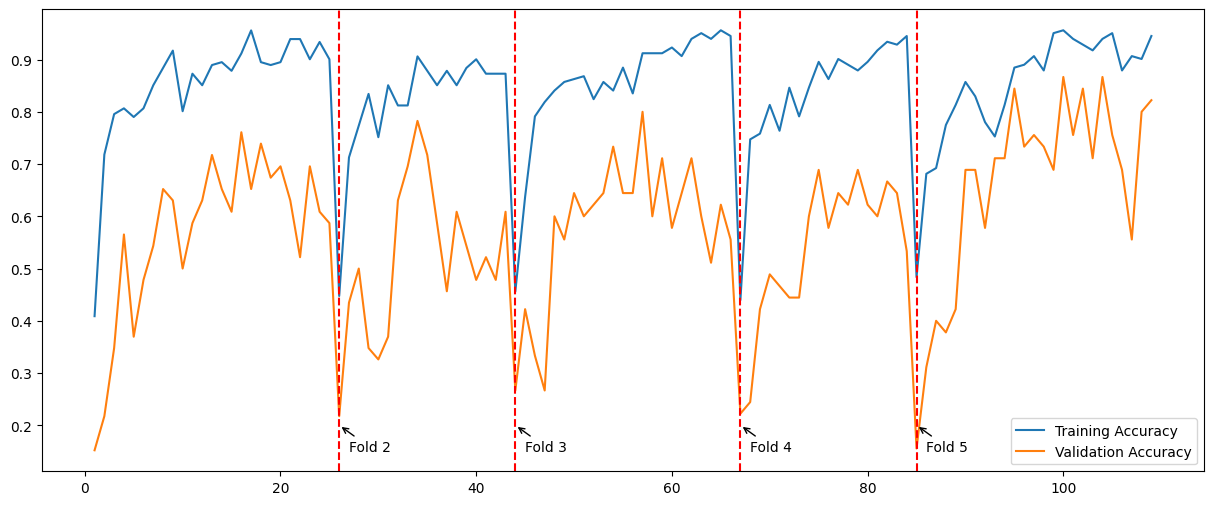

In [70]:
x1 = list(range(1, len(training_accuracy) + 1))
x2 = list(range(1, len(validation_accuracy) + 1))

fig = plt.figure(figsize=(15, 6))

# Create the plot
plt.plot(x1, training_accuracy, label='Training Accuracy')
plt.plot(x2, validation_accuracy, label='Validation Accuracy')



# Add points with labels
for i in range(k-1):
    plt.axvline(x=xs[i], color='red', linestyle='--')
# plt.axvline(x=xs[0], color='red', linestyle='--')
# plt.axvline(x=xs[1], color='red', linestyle='--')
# plt.axvline(x=xs[2], color='red', linestyle='--')
# plt.axvline(x=xs[3], color='red', linestyle='--')

# Add annotations to the lines
for i in range(k-1):
    plt.annotate('Fold '+str(i+2), xy=(xs[i], 0.2), xytext=(xs[i]+1, 0.15),
             arrowprops=dict(facecolor='black', arrowstyle='->'))

# plt.annotate('Fold 2', xy=(xs[0], 0.5), xytext=(xs[0]+1, 0.4),
#              arrowprops=dict(facecolor='black', arrowstyle='->'))
# plt.annotate('Fold 3', xy=(xs[1], 0.5), xytext=(xs[1]+1, 0.4),
#              arrowprops=dict(facecolor='black', arrowstyle='->'))
# plt.annotate('Fold 4', xy=(xs[2], 0.5), xytext=(xs[2]+1, 0.4),
#              arrowprops=dict(facecolor='black', arrowstyle='->'))
# plt.annotate('Fold 5', xy=(xs[3], 0.5), xytext=(xs[3]+1, 0.4),
#              arrowprops=dict(facecolor='black', arrowstyle='->'))
# plt.axvline(x=xs[4], color='red', linestyle='--')
# plt.scatter(xs, ys, color='red')
# plt.annotate('Point 1', (2, 4), textcoords="offset points", xytext=(0,10), ha='center')
# plt.annotate('Point 2', (4, 8), textcoords="offset points", xytext=(0,10), ha='center')


# Add a legend
plt.legend()

# Enable the grid
# plt.grid(True)

# Show the plot
plt.show()

In [ ]:
## Load the Model without any weight initialization
# model = EfficientNetLiteB0(classes=num_classes, weights=None, input_shape=input_shape, classifier_activation=None)
# model.summary()

In [ ]:
## Saving model
# model.save_weights('/home/ramez/Politechnika_Slaska_MSc/Thesis/Competition/submission/submit_19.h5')

In [ ]:
# model = EfficientNetLiteB0(classes=num_classes, weights=None, input_shape=input_shape, classifier_activation=None)
# # model = EfficientNetLiteB0(include_top=False, classes=num_classes, weights='imagenet', input_shape=input_shape, classifier_activation=None)
# model.load_weights('/home/ramez/Politechnika_Slaska_MSc/Thesis/Competition/submission/model_patterns_20epochs.h5')

The model will be now compiled and tested again. You should get the same score as before saving and loading. 

In [ ]:
# #Model shall be compiled before testing.
# model.compile()

# #Creating empty predictions
# predictions = np.zeros(len(y_test), dtype=np.int8)
# # inference loop
# for e, (image, target) in enumerate(zip(x_test, y_test)):
#     image = np.expand_dims(np.array(image), axis=0)
#     output = model.predict(image)
#     predictions[e] = np.squeeze(output).argmax()
# #Keras model score
# score_keras = 1 - cohen_kappa_score(y_test.numpy(), predictions)
# print("Score:",score_keras)